# Install and fetch requirements

In [ ]:
import os
import gc

# Train GPara

In [ ]:
EPOCHS = 46
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

## Environment Config

In [ ]:
RUN_ON_KAGGLE = False # Only run on `kaggle` or `colab`

run_on_colab = not RUN_ON_KAGGLE

## get dataset if needed

In [ ]:
if run_on_colab:

  if not os.path.exists("/root/.kaggle"):
    print("[-] Start Fetching Process...")
    from google.colab import userdata
    import json
    print("[-] Initiating kaggle client...")
    if not os.path.exists("kaggle.json"):
      with open("kaggle.json", 'w') as json_file:
          json.dump({"username": userdata.get('kaggle_uname'), "key": userdata.get('kaggle_api')}, json_file, indent=4)
    !pip install kaggle -q
    !mkdir ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

  if not os.path.exists("creditcardfraud.zip"):
    print("[-] Downloading dataset...")
    !kaggle datasets download -d mlg-ulb/creditcardfraud -q

  if not os.path.exists("creditcard.csv"):
    print("[-] Unzip downloaded dataset...")
    !unzip -q creditcardfraud.zip

print("[+] Dataset is ready.")

[+] Dataset is ready.


## Autoconfig

In [ ]:
if run_on_colab:
  DATASET_PATH = "creditcard.csv"
elif RUN_ON_KAGGLE:
  DATASET_PATH = "/kaggle/input/creditcardfraud/creditcard.csv"
else:
  print("Unknown environment")
  os.kill(os.getpid(), 9)

In [ ]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device>>", DEVICE)

# EDA

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm

import gc

In [ ]:
def add_percent_to_bars(ax):
  for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x()
    y = p.get_y()
    percent = height * 100
    percent_str = f"{percent:.1f}%"
    plt.text(x + width / 2, y + height / 2, percent_str,
             horizontalalignment="center",
             verticalalignment="center",
             rotation=90)

In [ ]:
dataset_raw = pd.read_csv(DATASET_PATH)

## Dataset statistics

In [ ]:
dataset_raw.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
dataset_raw.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


0    284315
1       492
Name: Class, dtype: int64


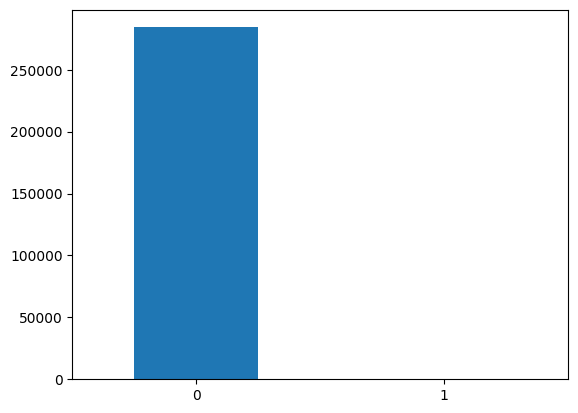

In [ ]:
tld = dataset_raw['Class'].value_counts().sort_values(ascending=False)
print(tld)
ax = tld.plot.bar()
plt.xticks(rotation=0)
plt.show()

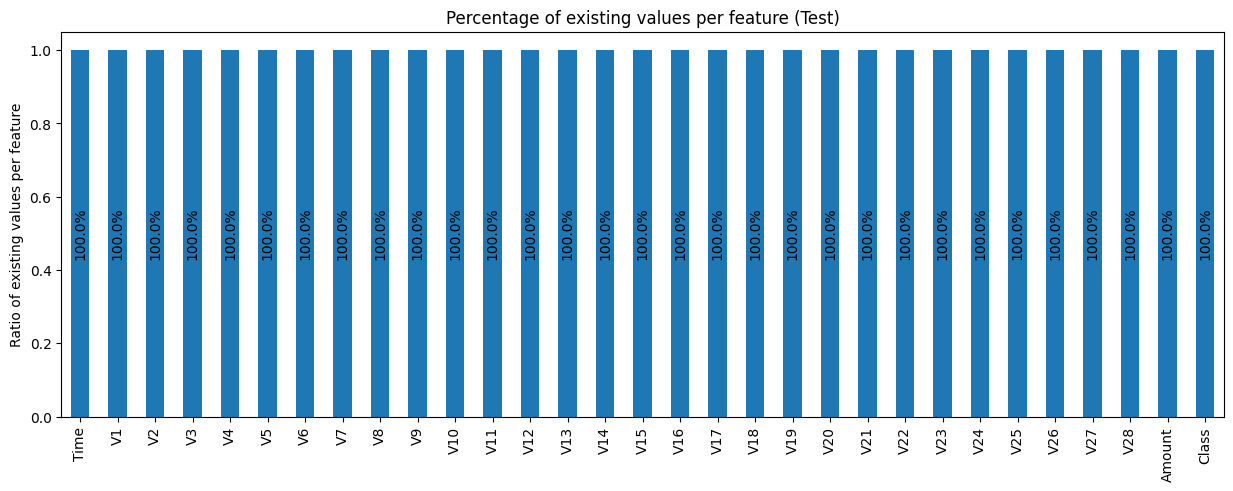

In [ ]:
ax = dataset_raw.notna().mean().plot(
    kind="bar", figsize=(15, 5),
    title="Percentage of existing values per feature (Test)",
    ylabel="Ratio of existing values per feature")
plt.xticks(rotation=90)
plt.ylim(bottom=0.000)
add_percent_to_bars(ax)

plt.show()

In [ ]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

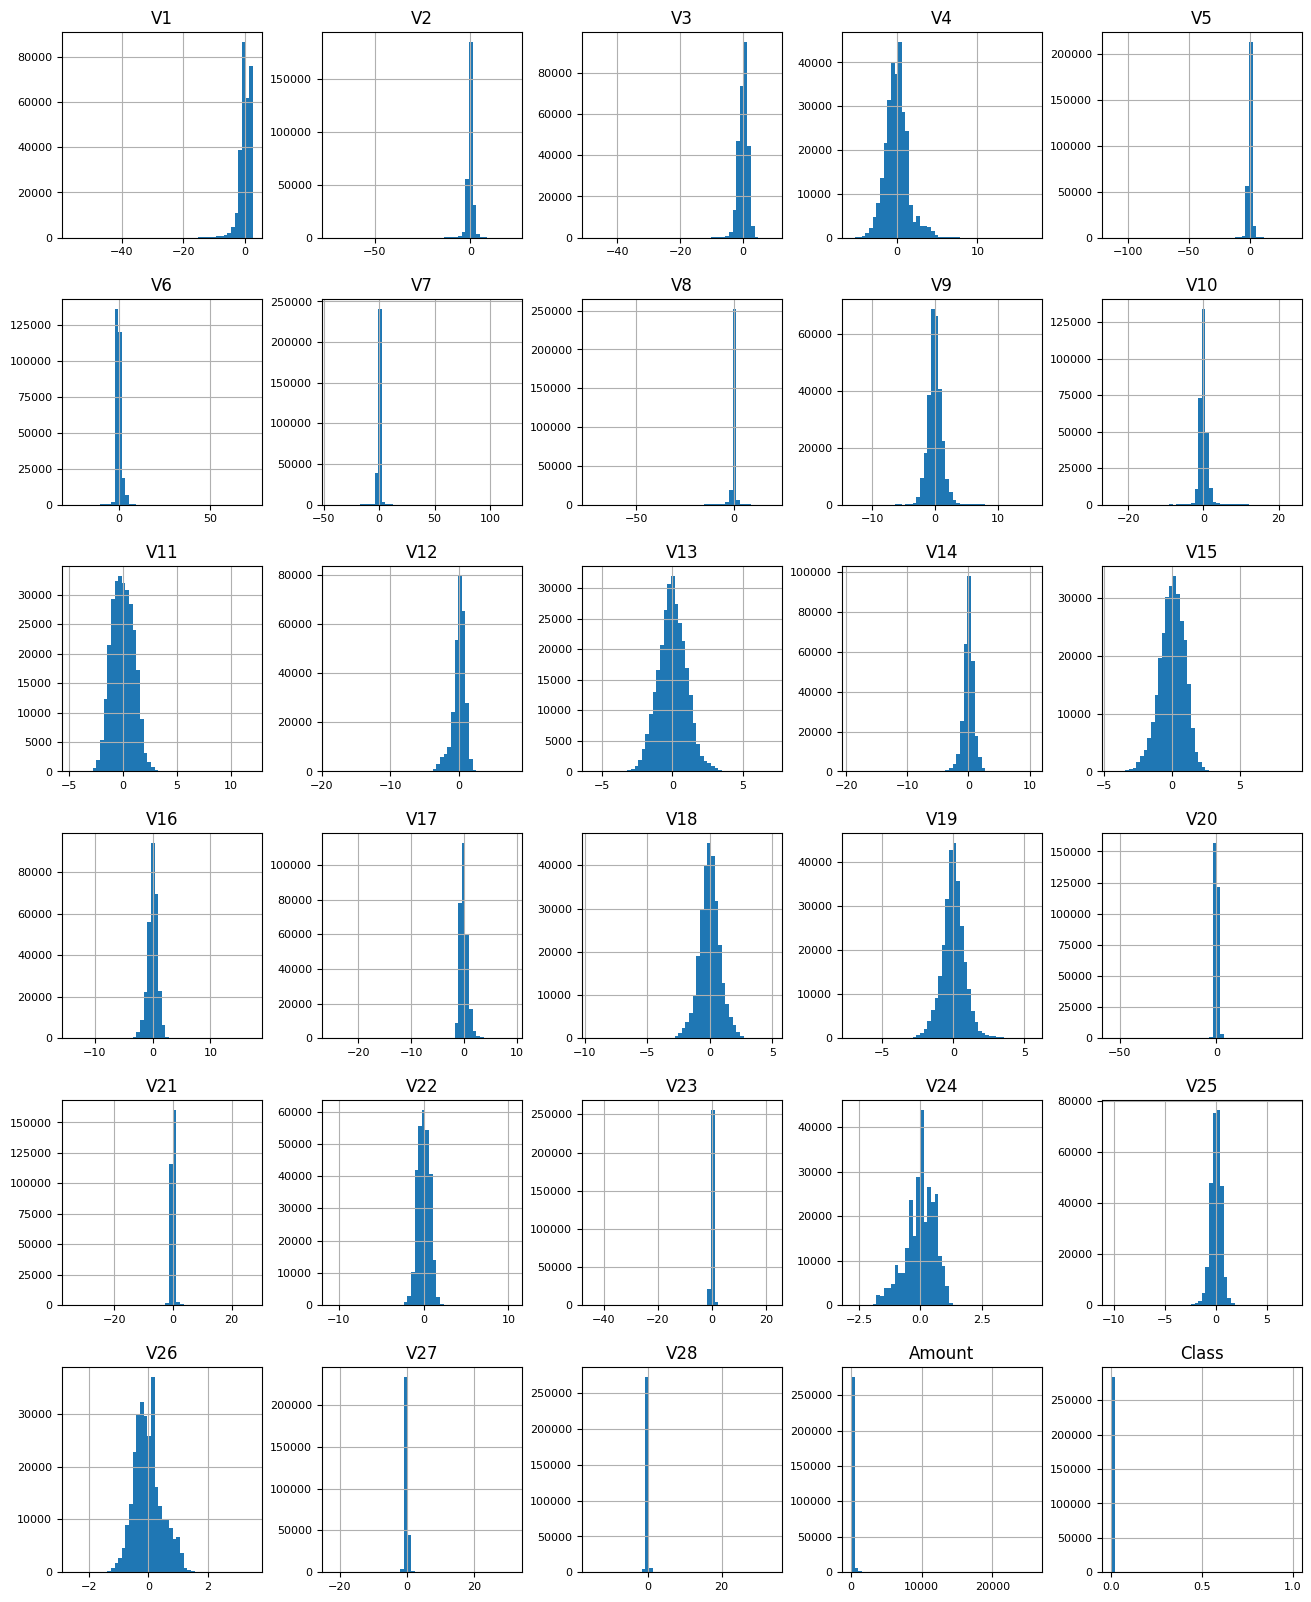

In [ ]:
dataset_raw.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

## Preprocess

In [ ]:
dataset_raw = dataset_raw.drop(columns=["Time"])

In [ ]:
dataset_raw.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [ ]:
dataset_raw.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data_v, label = dataset_raw.drop(columns=["Class"]), dataset_raw["Class"]

del dataset_raw

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

scaler.fit(data_v)
df_scaled = pd.DataFrame(scaler.transform(data_v), columns=data_v.columns)

del data_v

In [ ]:
df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-1.506872e-17,-9.580116e-18,-8.622104e-17,-5.189230e-18,3.832046e-17,9.979288e-18,1.237432e-17,-3.193372e-18,7.234983e-19,5.588401e-18,...,-1.247411e-18,-3.642440e-18,3.193372e-18,8.781773e-18,9.580116e-18,-5.029561e-17,5.887780e-18,2.444925e-18,-7.908585e-18,2.913952e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,-4.917360e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,-8.533551e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,4.168842e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,2.180758e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


## Split data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    df_scaled, label, test_size=0.2, random_state=42, stratify=label
)

# Model

In [ ]:
import torch
from torch import nn

class CCFraudDetector(nn.Module):
  def __init__(self, input_features, output_features):
    super(CCFraudDetector, self).__init__()
    pad = 1 if input_features%2==0 else 0
    self.network = nn.Sequential(
      nn.Conv1d(in_channels=input_features, out_channels=32, kernel_size=2, padding=pad),
      nn.ReLU(),
      nn.BatchNorm1d(num_features=32),
      nn.MaxPool1d(kernel_size=2, stride=2),
      nn.Dropout(p=0.2),
      
      nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
      nn.ReLU(),
      nn.BatchNorm1d(64),
      nn.MaxPool1d(kernel_size=2, stride=2),
      nn.Dropout(p=0.5),
      
      nn.Flatten(),
      
      nn.Linear(in_features=64, out_features=64),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      
      nn.Linear(in_features=64, out_features=output_features),
      nn.ReLU(),
    )
  
  def forward(self, x):
    out = self.network(x)
    return out

# Train Utils

In [ ]:
import torch
from torch.utils.data import DataLoader
import sklearn.metrics as metrics
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
@torch.no_grad()
def model_eval(model, loader, criterion):
  """Returns test_loss, test_acc"""
  test_loss = 0.0
  test_acc = 0.0
  total_samples = 0

  model.eval()
  itr = tqdm(loader, total=len(loader), leave=False)

  for samples, labels in itr:
      total_samples += len(samples)
      samples = samples.to(DEVICE)
      labels = labels.to(DEVICE)
          
      outputs = model(samples)

      loss = criterion(outputs, labels)

      test_loss += loss.item()

      _, preds = torch.max(outputs, 1)
      test_correct = torch.sum(preds == labels).item()
      test_acc += test_correct

      itr.set_description("(Eval)")
      itr.set_postfix(
          loss=round(test_loss/total_samples, 5),
          accuracy=round(test_acc/total_samples, 5),
      )

  test_loss = test_loss / len(loader)
  test_acc = test_acc / total_samples

  return test_loss, test_acc


In [ ]:
def train_model(
        model,
        batch_size,
        epochs,
        criterion,
        train_set,
        valid_set,
        test_set,
        lr=2e-5,
):

  train_losses = []
  train_accs = []

  valid_losses = []
  valid_accs = []

  test_losses = []
  test_accs = []

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

  itr = tqdm(train_loader, total=len(train_loader), leave=False)

  for epoch in range(epochs):
      model.train()
      epoch_loss = 0
      epoch_acc = 0
      epoch_samples = 0
      for idx, samples, labels in enumerate(itr, start=1):
          epoch_samples += len(labels)
          samples = samples.to(DEVICE)
          labels = labels.to(DEVICE)
          
          model.zero_grad()
          optimizer.zero_grad()

          outputs = model(samples)

          loss = criterion(outputs, labels)

          epoch_loss += loss.item()

          loss.backward()
          optimizer.step()

          _, preds = torch.max(outputs, 1)
          correct = torch.sum(preds == labels).item()
          epoch_acc += correct

          itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
          itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(epoch_acc/epoch_samples, 5),
          )

      epoch_loss = epoch_loss / len(train_loader)

      train_losses.append(epoch_loss)
      train_accs.append(epoch_acc/epoch_samples)

      model.eval()
      valid_loss, valid_acc = model_eval(
          model=model,
          loader=valid_loader
      )
      valid_losses.append(valid_loss)
      valid_accs.append(valid_acc)

      test_loss, test_acc = model_eval(
          model=model,
          loader=test_loader,
      )
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  history = {
    "train_loss": train_losses,
    "train_acc": train_accs,

    "valid_loss": valid_losses,
    "valid_acc": valid_accs,

    "test_loss": test_losses,
    "test_acc": test_accs,
  }
  return history

In [ ]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [ ]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset):

  loader = DataLoader(dataset, batch_size=32, shuffle=False)
  probabilities = []
  labels = []

  for samples, labels in tqdm(loader, leave=False, desc="Generate data"):

      probs = model(samples)

      probabilities.append(probs.detach())
      labels.append(labels.detach())

  probabilities = torch.cat(probabilities, dim=0)
  _, predicted = torch.max(probabilities.detach(), dim=1)
  labels = torch.cat(labels, dim=0).detach().cpu().squeeze().numpy()
  predicted = predicted.detach().cpu().squeeze().numpy()

  cm = metrics.confusion_matrix(
      y_true=labels,
      y_pred=predicted,
  )

  plt.figure(figsize=(10,10))
  sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
  plt.xlabel('Predicted Label', labelpad=20)
  plt.ylabel('True Label', labelpad=20)
  plt.title('Confusion Matrix', fontsize=30)

  recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
  f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
  precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
  report = metrics.classification_report(y_true=labels, y_pred=predicted)

  return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


# Blind Fine-Tuning

In [ ]:
from torch.utils.data import TensorDataset
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

In [ ]:
model = CCFraudDetector(input_features=29, output_features=2).to(DEVICE)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_valid, y_train_valid, test_size=0.25, random_state=42, stratify=y_train_valid
)

train_set = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
valid_set = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_set = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

del x_train, x_val, y_train, y_val

In [ ]:
history = train_model(
    model=model,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    criterion=BCEWithLogitsLoss(),
    train_set=train_set,
    valid_set=valid_set,
    test_set=test_set,
    lr=LEARNING_RATE,
)

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history["train_acc"]),
            ("Validation Acc", history["valid_acc"]),
            ("Test Acc", history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", history["train_loss"]),
            ("Validation Loss", history["valid_loss"]),
            ("Test Loss", history["test_loss"]),
        ]
    }
)

In [ ]:
cls_report = generate_confusion_matrix(
    model=model,
    dataset=test_set,
)

In [ ]:
print(f"Recall:    {cls_report['recall']:.3f}")
print(f"F1:        {cls_report['f1']:.3f}")
print(f"Precision: {cls_report['precision']:.3f}")
print(cls_report['report'])

In [ ]:
del model, history, cls_report

if torch.cuda.is_available():
  torch.cuda.empty_cache()
gc.collect()

# ADASYN Sampling